In [1]:
%matplotlib inline
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import pyplot as plt
import cmocean.cm as cmo
import xarray as xr
import xroms
from WaterMassProperties import fwh, pea

# Freshwater height and potential energy anomaly example
Here we illustrate how to extract data on the native ROMS model grid, and to plot maps of the freshwater height (FWH) and the potential energy anomaly (PEA). Under certain assumptions, these quantities can be shown to be proportional to the geostrophically balanced surface current stream function and the geostrophically balanced transport stream function, respectively, see Gustafsson [1]. The point is that, taken together, these derived parameters may highlight som aspects of the coastal ocean circulation which are strongly influenced by the freshwater distribution. For large FWH and small PEA, we have thin and fresh surface layers. Low FWH and high PEA indicate thick layers of high salinity.

The freshwater height is defined as

$$\mathrm{FWH} = \int_{-D + \zeta}^{\zeta} \frac{\mathrm{max}(S_\mathrm{ref}-S,0)}{S_\mathrm{ref}} dz,$$

where $S$ is the salinity and $S_\mathrm{ref}$ is a reference salinity value representative of open ocean conditions. The potential energy anomaly is defined similarly as

$$\mathrm{PEA} = -g\int_{-D + \zeta}^{\zeta} \frac{\mathrm{max}(\rho_\mathrm{ref}-\rho,0)}{\rho_\mathrm{ref}} dz.$$

Note that $D$ can be chosen arbitrarily, but plots may look strange in shallow areas whenever $D$ is chosen to be larger than the minimum depth of the model, which for Norkyst is 10 m. In such cases, it i recommended to mask out the areas where the water depth is smaller than $D$, see the example below. Also note that our layer is constant in thickness as it is always a distance $D$ downwards from whatever the surface coordinate $\zeta$ happens to be. Otherwise, we would see large variations associated with tides and surge etc., which is not really relevant for the freshwater dynamics we are interested in.  

In this notebook we will be fetching a subset of the full output file.

[1]: Gustafsson, B. (1999) "High frequency variability of the surface layers in the Skagerrak during SKAGEX", _Cont. Shelf Res._, **19**, pp. 1021–1047.

In [2]:
# ROMS file
romsfile = "https://thredds.met.no/thredds/dodsC/havvind/ocean/reference/REF-05/norkyst_avg_0031.nc"

In [3]:
# Define Norkyst projection
norkyst_crs = ccrs.Stereographic(central_latitude=90, central_longitude=70, true_scale_latitude=60,false_easting=3369600, false_northing=1844800)

In [4]:
# Open with xarray and make xroms object
ds = xr.open_dataset(romsfile)
ds, xgrid = xroms.roms_dataset(ds)

In [5]:
# List CF axes that can be used for data access.
# ds.salt.cf.describe()

In [6]:
# Make subset for Skagerrak
ds = ds.cf.isel(X=slice(0,1000), Y=slice(0,1000))

In [7]:
# Calculate freshwater height
max_depth = -20.0
FWH = fwh(ds.salt.values, ds.z_w.values, maxdepth=max_depth)

# Choosing first time record, flatten and set to NaN where it is shallower than maximum depth.
FWH = FWH[0,:,:].squeeze() 
FWH[np.where(ds.h.values<-max_depth)] = np.nan

In [8]:
# Calculate potential energy anomaly
max_depth = -20.0
PEA = pea(ds.rho.values, ds.z_w.values, maxdepth=max_depth)

# Choosing first time record, flatten and set to NaN where it is shallower than maximum depth.
PEA = PEA[0,:,:].squeeze() 
PEA[np.where(ds.h.values<-max_depth)] = np.nan

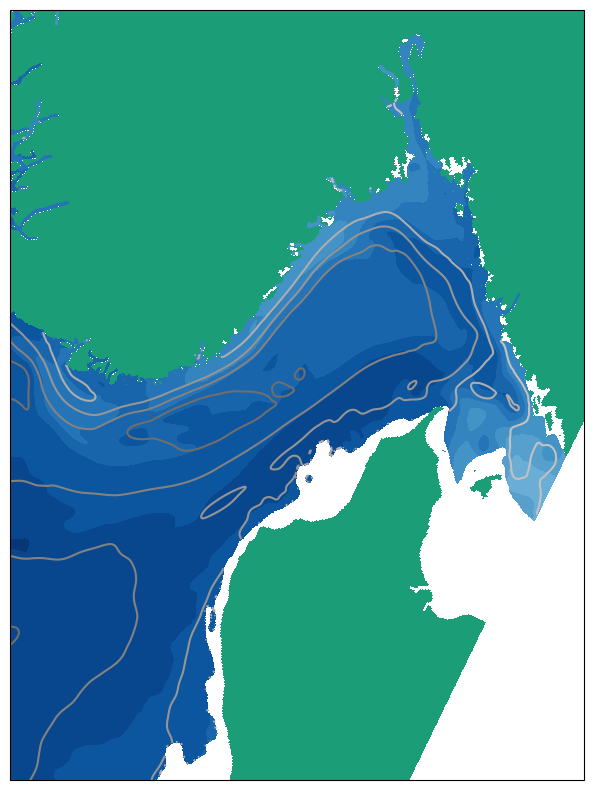

In [ ]:
# Prepare map projection
proj = ccrs.AzimuthalEquidistant(central_longitude=5, central_latitude = 60)
fig, ax = plt.subplots(figsize=(10,10),subplot_kw=dict(projection=proj), ncols=1, nrows = 1)
ax.set_extent([6, 11.8, 55.7, 60], ccrs.PlateCarree())

# Force shallow areas with depth < D to appear as white. Land will be green.
maskmap = plt.cm.Dark2
maskmap.set_bad('w')
maskrho = ds.mask_rho.values
maskrho[np.where(maskrho>0.5)] = np.nan
ax.pcolormesh(ds.lon_rho.values, ds.lat_rho.values, maskrho, transform=ccrs.PlateCarree(), cmap=maskmap)

# Plot values of FWH (filled contours) and PEA (contour lines).
ax.contourf(ds.lon_rho.values, ds.lat_rho.values, FWH, 15, transform=ccrs.PlateCarree(), cmap=plt.cm.Blues_r)
ax.contour(ds.lon_rho.values, ds.lat_rho.values, PEA, 15, transform=ccrs.PlateCarree(), cmap=plt.cm.Greys)